In [50]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy.cluster.hierarchy as sch
from itertools import product

In [2]:
colors = {
    '0h'  : "#fde72580", 
    '1h'  : "#37b57880",
    '4h'  : "#21908d80",
    '7h'  : "#31668d80",
    '10h' : "#43377f80",
    '24h' : "#44015480",
    'w24h': '#fb852480',
#     'w48h': '#00000080',
}

In [3]:
plt.rcParams["font.family"] = "Arial Narrow"

In [5]:
# Load compartments
comps = pd.read_csv('../../data/ComplementaryData/HiC/p53_normalized_compartments.tsv', sep='\t', index_col=0)

In [6]:
comps

,Chromosome,Start,End,WT-NUT-0h,WT-NUT-1h,WT-NUT-4h,WT-NUT-7h,WT-NUT-10h,WT-NUT-24h,WT-NUT-w24h
0,1,1,100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100001,200000,NaN,NaN,NaN,NaN,NaN,NaN,0.190503
2,1,200001,300000,NaN,NaN,NaN,NaN,NaN,NaN,0.243394
3,1,300001,400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,400001,500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
30371,X,154800001,154900000,0.189703,0.199737,0.254933,0.191116,0.221287,0.22803,0.314355
30372,X,154900001,155000000,0.194494,0.220903,0.283882,0.197022,0.234084,NaN,0.342265
30373,X,155000001,155100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30374,X,155100001,155200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
comps.columns

Index(['Chromosome', 'Start', 'End', 'WT-NUT-0h', 'WT-NUT-1h', 'WT-NUT-4h',
       'WT-NUT-7h', 'WT-NUT-10h', 'WT-NUT-24h', 'WT-NUT-w24h'],
      dtype='object')

In [12]:
scores = comps[['WT-NUT-0h', 'WT-NUT-1h', 'WT-NUT-4h', 'WT-NUT-7h',
                'WT-NUT-10h', 'WT-NUT-24h', 'WT-NUT-w24h']].copy().dropna()

Keep only bins with compartment value in non-washout samples

In [13]:
scores = scores[~((scores[scores.columns[:-1]] >= 0).all(axis=1) | 
                  (scores[scores.columns[:-1]] <= 0).all(axis=1))]

In [14]:
scores

,WT-NUT-0h,WT-NUT-1h,WT-NUT-4h,WT-NUT-7h,WT-NUT-10h,WT-NUT-24h,WT-NUT-w24h
153,0.011164,0.106230,0.108810,0.028211,-0.063010,-0.075065,0.041166
339,0.040125,0.126925,0.043011,0.017711,-0.093342,-0.121845,0.132262
352,-0.000628,0.010891,0.018699,-0.043266,-0.125760,-0.142514,0.080923
353,0.137670,0.078944,0.112367,0.064660,0.022274,-0.038727,0.220314
370,0.096255,0.098795,0.098598,0.079344,0.013585,-0.063419,0.154739
...,...,...,...,...,...,...,...
30034,-0.009126,-0.068747,-0.095204,-0.150609,0.017788,-0.025203,-0.278030
30048,0.020299,0.024051,0.042006,0.023200,-0.026892,0.100664,-0.015784
30184,-0.036611,0.005975,-0.013474,-0.021075,-0.086389,0.003154,-0.000827
30210,0.026121,-0.043897,0.068201,0.004562,-0.012778,0.016112,-0.044116


### Overlap between DMSO and Nut 24h or washout conditions

In [41]:
print(f"Percetange overlapping DMSO (cut: {cut})")
avo = []
for tp in ['24h', 'w24h']:
    v = len(scores[((scores[f"WT-NUT-0h"  ] >  0) & (scores[f"WT-NUT-{tp}"] >  0)) | 
                    (scores[f"WT-NUT-0h"  ] < -0) & (scores[f"WT-NUT-{tp}"] < -0)])
    avo.append((v) / len(scores))
    print(f"{tp:>6}  {(v) / len(scores):>8.3f}")
print(avo[0] / avo[1])

Percetange overlapping DMSO (cut: 0.5)
   24h     0.498
  w24h     0.532
0.9368770764119602


## Clustering

In [42]:
Y = sch.linkage(scores[['WT-NUT-0h', 'WT-NUT-1h' , 'WT-NUT-4h' , 
                        'WT-NUT-7h', 'WT-NUT-10h', 'WT-NUT-24h', 'WT-NUT-w24h']], 
                method='average', optimal_ordering=True)

In [43]:
Z1 = sch.dendrogram(Y, orientation='left', no_plot=True, color_threshold=0, above_threshold_color='k') #link_color_func=lambda x: 'k')
idx1 = np.array(Z1['leaves'])
D = scores.to_numpy()[idx1,:]

In [45]:
upper = lambda x: x > 0
lower = lambda x: x < 0

In [46]:
np.concatenate([np.ones((3, 2)), np.zeros((3, 2))])

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [47]:
C6 = None
C7 = None
for t1, t2, t3, t4, t5, t6 in list(product([upper, lower], repeat=6))[1:-1]:
    tmp = D[t1(D[:,0]) & t2(D[:,1]) & t3(D[:,2]) & t4(D[:,3]) & t5(D[:,4]) & t6(D[:,5])]
    if (len(tmp) / len(D) * 100) < 1:
        if C7 is None:
            C7 = tmp.copy()
        else:
            C7 = np.concatenate([C7, tmp])
    elif (len(tmp) / len(D) * 100) < 5:
        if C6 is None:
            C6 = tmp.copy()
        else:
            C6 = np.concatenate([C6, tmp])

#### group hierarchical clusters with more heterogeneity

In [48]:
C3 = D[(D[:,0] > 0) & (D[:,1] > 0) & (D[:,2] > 0) & (D[:,3] > 0) & (D[:,4] < 0) & (D[:,5] > 0)]
C4 = D[(D[:,0] > 0) & (D[:,1] > 0) & (D[:,2] > 0) & (D[:,3] > 0) & (D[:,4] > 0) & (D[:,5] < 0)]
C5 = D[(D[:,0] > 0) & (D[:,1] > 0) & (D[:,2] > 0) & (D[:,3] > 0) & (D[:,4] < 0) & (D[:,5] < 0)]

C1 = D[(D[:,0] < 0) & (D[:,1] > 0) & (D[:,2] > 0) & (D[:,3] > 0) & (D[:,4] < 0) & (D[:,5] < 0)]
C2 = D[(D[:,0] < 0) & (D[:,1] > 0) & (D[:,2] < 0) & (D[:,3] < 0) & (D[:,4] < 0) & (D[:,5] < 0)]

In [49]:
D = np.concatenate((C1, C2, C3, C4, C5, C6, C7), axis=0)

### plot

In [51]:
mycmap = LinearSegmentedColormap.from_list('lala', 
                                           ["#23447F", "#9298BA", "#FFFAFA", "#CE8B7F", "#880F10"], N=256)

Text(-0.65, 0.3, 'Compartment score')

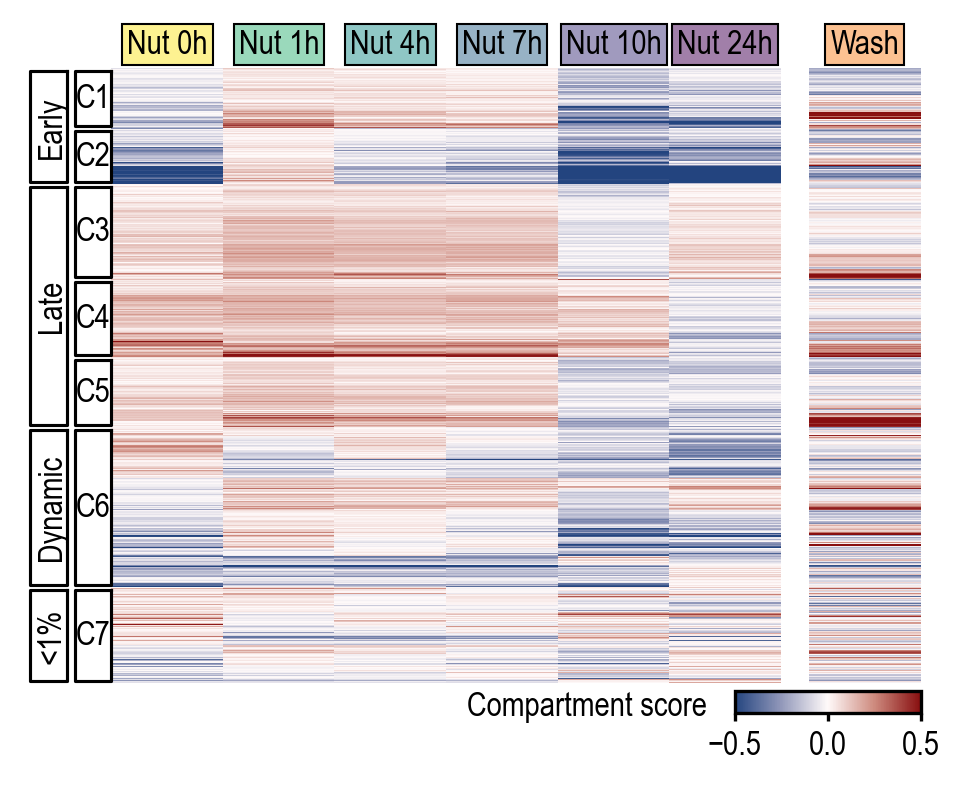

In [53]:
fig = plt.figure(figsize=(3.1, 2.5), dpi=300)
axmatrix = fig.add_axes([0.11, 0.1, 0.72, 0.82])
axwash   = fig.add_axes([0.86, 0.1, 0.12, 0.82])
pos = 0
w = len(D) * 0.004
prev_b = 0
meta = {2: 'Early', 5: 'Late', 6: 'Dynamic', 7: '<1%'}
for c, h in enumerate([len(C1), len(C2), len(C3), len(C4), len(C5), len(C6), len(C7)], 1):
    b = pos
    e = pos + h
    axmatrix.text(-0.82, (b + e) / 2, f"C{c}", size=8, va='center')
    axmatrix.plot([-0.5, -0.83, -0.83, -0.5, -0.5], 
                  [b + w, b + w, e - w, e - w, b + w], 
                  'k', lw=0.75, clip_on=False, alpha=1)
    if c in [2, 5, 6, 7]:
        axmatrix.plot([-0.9 , -1.23, -1.23, -0.9 , -0.9], 
                      [prev_b + w, prev_b + w, e - w, e - w, prev_b + w], 
                      'k', lw=0.75, clip_on=False, alpha=1)
        axmatrix.text(-1.17, (prev_b + e) / 2, meta[c], size=8, va='center', rotation=90)
        prev_b = e
        
    pos = e

im = axmatrix.matshow(D[:,:-1], aspect='auto', origin='upper', cmap=mycmap, vmin=-0.5, vmax=0.5)
im = axwash.matshow(D[:,-1:], aspect='auto', origin='upper', cmap=mycmap, vmin=-0.5, vmax=0.5)
axmatrix.axison = False
axwash.axison = False

for n, sample in enumerate(scores.columns[:-1]):
    t0 = sample.split('-')[-1]
    axmatrix.text(n, 0 - len(scores) * 0.025, f"Nut {t0}", 
                  size=8, ha='center', bbox=dict(boxstyle="square", ec=(0, 0, 0, 1), lw=0.5,
                                                 fc=colors[t0], alpha=None, pad=0.15))

axwash.text(0, 0 - len(scores) * 0.025, "Wash", 
              size=8, ha='center', bbox=dict(boxstyle="square", ec=(0, 0, 0, 1), lw=0.5,
                                             fc=colors["w24h"], alpha=None, pad=0.15))
    
cax = fig.add_axes([0.78, 0.06, 0.2, 0.03])
plt.colorbar(im, cax=cax, orientation="horizontal")
cax.tick_params(labelsize=8, length=2, pad=2)
cax.text(-0.65, 0.3, 'Compartment score', va='center', ha='right', size=8)
# plt.savefig('some_path.pdf', dpi=300)
# plt.savefig('some_path.png', dpi=300)